In [1]:
%reload_ext autoreload
%autoreload 2

In [37]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
    custom_plots,
    compress_repeated_epochs
)
from ripple_heterogeneity.assembly import assembly_reactivation,find_sig_assembly
from ripple_heterogeneity.readout import assembly_multi_region
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import os
from statannot import add_stat_annotation
from statannotations.Annotator import Annotator
from neo.rawio import neuroscoperawio
import nelpy.plotting as npl

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [3]:
import pickle
session = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_v1\Z__Data_HMC1_day10.pkl"
# session = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_v1\Z__Data_AYAold_AYA9_day15.pkl"

# Z:\Data\AYAold\AYA9\day15
with open(session, "rb") as f:
    results = pickle.load(f)

In [22]:
from xml.etree import ElementTree
def parse_xml_channel_groups(filename):
    filename = filename.replace('.xml', '').replace('.dat', '')

    tree = ElementTree.parse(filename + '.xml')
    root = tree.getroot()

    # find channels
    channel_group = []
    for grp_index, xml_chx in enumerate(
            root.find('anatomicalDescription').find('channelGroups').findall('group')):
        for xml_rc in xml_chx:
            channel_group.append([int(xml_rc.text),grp_index])
    return np.array(channel_group)

reader = neuroscoperawio.NeuroScopeRawIO('Z:/Data/HMC1/day10/day10')
reader.parse_header()
channel_group = parse_xml_channel_groups(reader.filename)
shank = 9
channel_indexes = channel_group[channel_group[:,1] == shank,0]

In [23]:
channel_indexes

array([288, 301, 306, 319, 302, 305, 289, 303, 304, 290, 300, 307, 291,
       299, 308, 292, 298, 309, 293, 297, 310, 318, 296, 311, 317, 295,
       312, 316, 294, 313, 315, 314])

In [28]:
channel_indexes = [293,314]
rip = 0
seconds_idx = np.array([results["react"].ripples[rip].start,results["react"].ripples[rip].stop])

# convert to index
to_idx = (seconds_idx*reader.get_signal_sampling_rate()).astype(int)
# get chunk of data
raw_sigs = reader.get_analogsignal_chunk(i_start=to_idx[0],
                                        i_stop=to_idx[1],
                                        channel_indexes=channel_indexes)

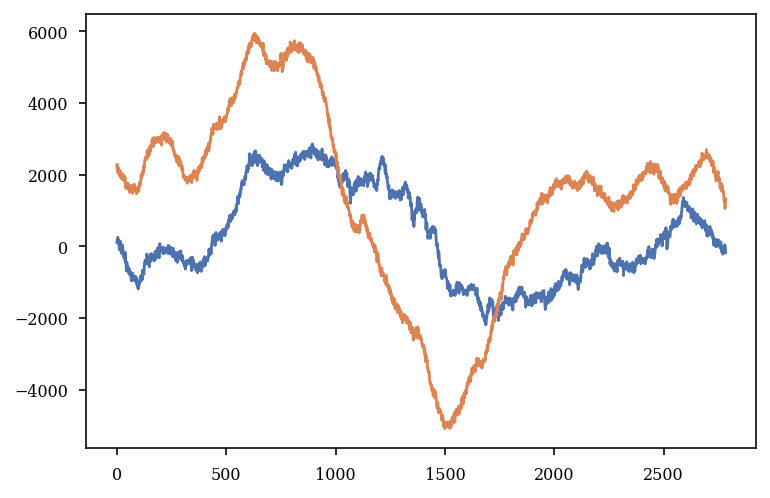

In [29]:
plt.plot(raw_sigs)

In [12]:
results

{'assembly_act_pre': <AnalogSignalArray at 0x1f265093490: 45 signals (4,052 segments)> for a total of 12:33:524 minutes,
 'assembly_act_task': <AnalogSignalArray at 0x1f26509d8e0: 45 signals (776 segments)> for a total of 2:11:762 minutes,
 'assembly_act_post': <AnalogSignalArray at 0x1f26509dbe0: 45 signals (5,227 segments)> for a total of 16:20:389 minutes,
 'react': <ripple_heterogeneity.assembly.assembly_reactivation.AssemblyReact at 0x1f26509de20>}

In [13]:
patterns, is_member_sig, keep_assembly, is_member = find_sig_assembly.main(
    results.get("react").patterns
)

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


In [82]:
df_strength = assembly_multi_region.load_reactivation(results)

labels = ["deep_mec", "deep_pfc", "superficial_mec", "superficial_pfc"]

df_strength["single_cross_region"] = df_strength[labels].sum(axis=1) == 1

out = [labels[val] for val in np.argmax(df_strength[labels].values,axis=1)]
df_strength["single_cross_region_label"] = out
df_strength.loc[df_strength.single_cross_region==False,"single_cross_region_label"] = 'unknown'

deep_mec_assem_n = df_strength[df_strength.single_cross_region_label == "deep_mec"].assembly_n.unique()
deep_pfc_assem_n = df_strength[df_strength.single_cross_region_label == "deep_pfc"].assembly_n.unique()
superficial_mec_assem_n = df_strength[df_strength.single_cross_region_label == "superficial_mec"].assembly_n.unique()
superficial_pfc_assem_n = df_strength[df_strength.single_cross_region_label == "superficial_pfc"].assembly_n.unique()

In [94]:
deep_mec_assem_n, deep_pfc_assem_n, superficial_mec_assem_n, superficial_pfc_assem_n

(array([], dtype=float64),
 array([ 4., 13., 19.]),
 array([], dtype=float64),
 array([32.]))

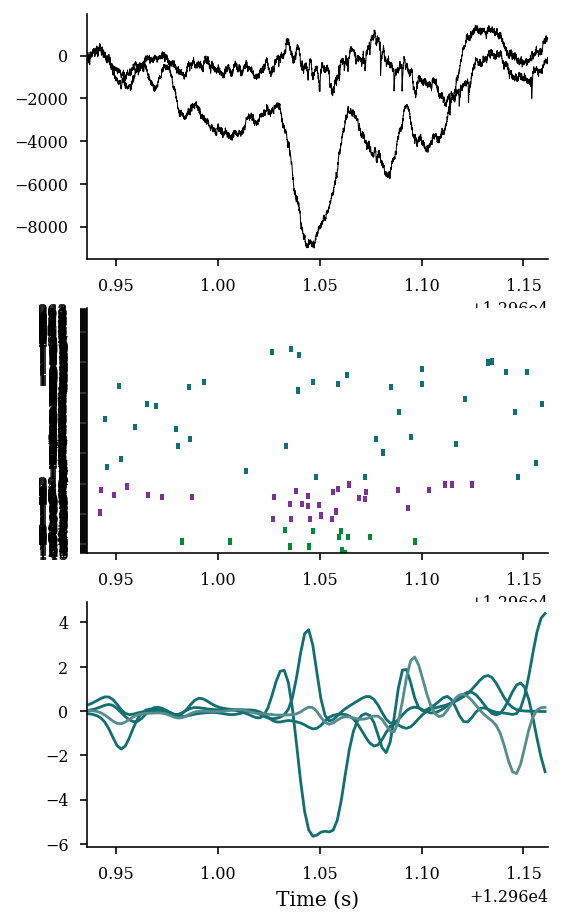

In [110]:
rip = 5439

fig, axs = plt.subplots(3,1,figsize=functions.set_size("thesis", fraction=0.7, subplots=(3, 1)),edgecolor=None)
fig.subplots_adjust(hspace=.2, wspace=0.1)
axs = axs.ravel()

# plot raw signal
channel_indexes = [293, 314]

seconds_idx = np.array(
    [results["react"].ripples[rip].start, results["react"].ripples[rip].stop]
)
# convert to index
to_idx = (seconds_idx * reader.get_signal_sampling_rate()).astype(int)
# get chunk of data
raw_sigs = reader.get_analogsignal_chunk(
    i_start=to_idx[0], i_stop=to_idx[1], channel_indexes=channel_indexes
)
ts = np.linspace(
    results["react"].ripples[rip].start,
    results["react"].ripples[rip].stop,
    raw_sigs.shape[0],
)

axs[0].plot(ts, raw_sigs, color="k",linewidth=0.5)

# plot raster
group_colors = {
    "MEC": "#de2020",
    "PFC": "#116f70",
    "Deep": "#7b3294",
    "Superficial": "#008837",
}
group_colors_assemblies = {
    "deep_mec": "#de2020",
    "superficial_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "superficial_pfc": "#568c8c",
}
ca1_deep_idx = results["react"].cell_metrics.brainRegion.str.contains("CA1") & results[
    "react"
].cell_metrics.deepSuperficial.str.contains("Deep")
ca1_sup_idx = results["react"].cell_metrics.brainRegion.str.contains("CA1") & results[
    "react"
].cell_metrics.deepSuperficial.str.contains("Superficial")
pfc_idx = results["react"].cell_metrics.brainRegion.str.contains("PFC")
mec_idx = results["react"].cell_metrics.brainRegion.str.contains("MEC")

npl.rasterplot(
    results["react"].st.iloc[:, ca1_sup_idx][results["react"].ripples[rip]],
    lw=2,
    lh=6,
    ax=axs[1],
    color=group_colors["Superficial"],
    vertstack=True,
)
npl.rasterplot(
    results["react"].st.iloc[:, ca1_deep_idx][results["react"].ripples[rip]],
    lw=2,
    lh=6,
    ax=axs[1],
    color=group_colors["Deep"],
    vertstack=True,
)
npl.rasterplot(
    results["react"].st.iloc[:, pfc_idx][results["react"].ripples[rip]],
    lw=2,
    lh=6,
    ax=axs[1],
    color=group_colors["PFC"],
    vertstack=True,
)
npl.rasterplot(
    results["react"].st.iloc[:, mec_idx][results["react"].ripples[rip]],
    lw=2,
    lh=6,
    ax=axs[1],
    color=group_colors["MEC"],
    vertstack=True,
)

# plot assembly strength
axs[2].plot(
    results["assembly_act_post"][results["react"].ripples[rip]].abscissa_vals,
    results["assembly_act_post"][results["react"].ripples[rip]].data[deep_pfc_assem_n.astype(int),:].T,
    color=group_colors_assemblies["deep_pfc"],
)
axs[2].plot(
    results["assembly_act_post"][results["react"].ripples[rip]].abscissa_vals,
    results["assembly_act_post"][results["react"].ripples[rip]].data[superficial_pfc_assem_n.astype(int),:].T,
    color=group_colors_assemblies["superficial_pfc"],
)
sns.despine()
axs[2].set_xlabel("Time (s)")

for ax in axs:
    ax.set_xlim(results["react"].ripples[rip].start, results["react"].ripples[rip].stop)


In [107]:

np.where(results["react"].ripples.starts > results["assembly_act_post"].abscissa_vals.min())

(array([ 5438,  5439,  5440, ..., 11458, 11459, 11460], dtype=int64),)

In [104]:

results["react"].ripples.starts

array([5.05720000e+00, 6.10040000e+00, 6.62040000e+00, ...,
       2.23778900e+04, 2.23780628e+04, 2.23813308e+04])

array([32.])

In [68]:
from ripple_heterogeneity.readout import ca1_assembly_downstream_psth

def construct_assembly_df(r):
    # construct dataframe with assembly data
    assembly_df = pd.DataFrame()
    # find significant assemblies and significant members
    _, _, keep_assembly, is_member = find_sig_assembly.main(r.patterns)
    # get assembly dataframe using code from previous analysis
    results = {"react": r}
    assembly_df_temp = ca1_assembly_downstream_psth.get_assembly_df(
        results, r.patterns, is_member
    )

    # add if the assembly is significant
    keep_assembly_df = pd.DataFrame(
        index=np.arange(r.patterns.shape[0]), data=keep_assembly
    )
    keep_assembly_dict = keep_assembly_df.to_dict()
    assembly_df_temp["assembly_keep"] = assembly_df_temp["assembly_n"]
    assembly_df_temp["assembly_keep"] = assembly_df_temp["assembly_keep"].map(
        keep_assembly_dict[0]
    )

    # add brain region
    assembly_df_temp["region"] = r.brainRegion
    assembly_df = pd.concat([assembly_df, assembly_df_temp], ignore_index=True)

    # add offset to assembly_n
    assem_offset = 0
    for region in assembly_df.region.unique():
        assembly_df.loc[assembly_df.region == region, "assembly_n"] = (
            assembly_df[assembly_df.region == region].assembly_n.values + assem_offset
        )
        # update offset
        assem_offset = assembly_df[assembly_df.region == region].assembly_n.max() + 1
    return assembly_df

# def add_affiliation(assembly_df):

#     labels = ["Superficial", "Deep"]
#     assembly_df["affiliation"] = "unknown"

#     # iterate over potential assembly labels
#     for n in assembly_df.assembly_n.unique():
#         # pull out current assembly and units that assembly members
#         cur_assembly = assembly_df[
#             (assembly_df.assembly_n == n)
#             & (assembly_df.is_member == True)
#         ]
#         if cur_assembly.shape[0] == 0:
#             continue
#         # if there no ca1 in the assembly, assign it to the cortex

#         if cur_assembly.brainRegion.str.contains("PFC").all():
#             assembly_df.loc[(assembly_df.assembly_n == n),"affiliation"] = "PFC"

#         elif cur_assembly.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC").all():
#             assembly_df.loc[(assembly_df.assembly_n == n),"affiliation"] = "MEC"

#         # if there is a ca1 in the assembly, assign it to the deep or superficial
#         for label in labels:
#             if (cur_assembly.deepSuperficial == label).all():
#                 assembly_df.loc[(assembly_df.assembly_n == n),"affiliation"] = label
#     return assembly_df

assembly_df = construct_assembly_df(results["react"])

# assembly_df = add_affiliation(assembly_df)
assembly_df

,patterns,is_member,assembly_n,UID,putativeCellType,brainRegion,deepSuperficial,deepSuperficialDistance,assembly_keep,region
0,0.058877,False,0,3,Pyramidal Cell,PFC,Cortical,NaN,True,CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC
1,0.131953,False,0,4,Pyramidal Cell,PFC,Cortical,NaN,True,CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC
2,0.443478,True,0,5,Pyramidal Cell,PFC,Cortical,NaN,True,CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC
3,0.015643,False,0,6,Pyramidal Cell,PFC,Cortical,NaN,True,CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC
4,-0.048616,False,0,7,Pyramidal Cell,PFC,Cortical,NaN,True,CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC
...,...,...,...,...,...,...,...,...,...,...
11830,-0.029295,False,44,372,Pyramidal Cell,MEC,Cortical,NaN,True,CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC
11831,0.001367,False,44,375,Pyramidal Cell,MEC,Cortical,NaN,True,CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC
11832,-0.036117,False,44,380,Pyramidal Cell,MEC,Cortical,NaN,True,CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC
11833,0.018375,False,44,381,Pyramidal Cell,MEC,Cortical,NaN,True,CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC


In [67]:
assembly_df.affiliation.value_counts()

unknown    9468
PFC        2104
MEC         263
Name: affiliation, dtype: int64

In [63]:
assembly_df[assembly_df.deepSuperficial.str.contains("Deep") & (assembly_df.assembly_keep == True) & (assembly_df.is_member == True)]

,patterns,is_member,assembly_n,UID,putativeCellType,brainRegion,deepSuperficial,deepSuperficialDistance,assembly_keep,region,affiliation
1210,-0.440696,True,4,216,Pyramidal Cell,CA1sp,Deep,-103.816284,True,CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC,unknown
1718,-0.494323,True,6,195,Pyramidal Cell,CA1so,Deep,-88.816284,True,CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC,unknown
1773,-0.303780,True,6,261,Pyramidal Cell,CA1sp,Deep,-36.303741,True,CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC,unknown
1776,-0.511397,True,6,264,Pyramidal Cell,CA1sp,Deep,-103.816284,True,CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC,unknown
2311,0.272545,True,8,273,Pyramidal Cell,CA1sp,Deep,-73.816284,True,CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC,unknown
2314,0.595740,True,8,276,Pyramidal Cell,CA1so,Deep,-133.816284,True,CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC,unknown
2513,0.217253,True,9,202,Pyramidal Cell,CA1sp,Deep,-73.816284,True,CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC,unknown
2541,0.155506,True,9,233,Pyramidal Cell,CA1sp,Deep,-103.816284,True,CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC,unknown
2573,0.236503,True,9,272,Pyramidal Cell,CA1sp,Deep,-73.816284,True,CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC,unknown
3049,-0.389595,True,11,214,Pyramidal Cell,CA1sp,Deep,-103.816284,True,CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC,unknown


In [56]:
assembly_df.affiliation.value_counts()

unknown    10783
PFC          789
MEC          263
Name: affiliation, dtype: int64